In [1]:
import tensorflow as tf
import numpy as np
import gym
from gym.spaces import Box, Discrete
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer(object):
    """
    A simple FIFO experience replay buffer for all agents.
    """

    def __init__(self, obs_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros(size, dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

In [3]:
"""
Actor-Critics
"""
def mlp(x, hidden_sizes=(32,), activation=tf.tanh, output_activation=None):
    for h in hidden_sizes[:-1]:
        x = tf.layers.dense(x, units=h, activation=activation)
    return tf.layers.dense(x, units=hidden_sizes[-1], activation=output_activation)


def mlp_categorical_policy(x, a, act_dim, hidden_sizes, activation=tf.tanh, output_activation=None):
    qvalue = mlp(x, list(hidden_sizes)+[act_dim], activation, output_activation)
    pi = tf.argmax(qvalue,1)
    index = tf.stack([tf.range(tf.shape(a)[0]), a], axis=1)
    q_sa = tf.gather_nd(qvalue, index)
    qmax = tf.reduce_max(qvalue, axis=1)
    return pi, q_sa, qmax

In [4]:
def get_vars(scope):
    return [x for x in tf.global_variables() if scope in x.name]

In [5]:
class DQN(object):
    #离散动作空间
    def __init__(self, **kwargs):
        self.init_hyperparameters(**kwargs)
        self.replay_buffer = ReplayBuffer(obs_dim=self.obs_dim, size=self.hyperparameters['replay_size'])
        self.init_algorithm()
        pass
    
    def init_hyperparameters(self, **kwargs):
        self.hyperparameters = dict(env='CartPole-v0', seed=0, epochs=100, step_per_epoch=5000, replay_size=int(1e6), 
                                   gamma=0.99, batch_size=100, max_ep_len=1000, act_noise=0.1, lr=1e-3, epsilon=0.1,
                                   hidden_sizes = (40,))
        
        for param in kwargs:
            self.hyperparameters[param] = kwargs[param]
            
        self.env = gym.make(self.hyperparameters['env'])
        self.obs_dim = self.env.observation_space.shape[0]
        self.act_dim = self.env.action_space.n if isinstance(self.env.action_space, Discrete) else self.env.action_space.shape[0]
        
        tf.set_random_seed(self.hyperparameters['seed'])
        np.random.seed(self.hyperparameters['seed'])
        
        self.mean_rew = []
        
    def init_algorithm(self):
        #算法初始化，包括网络初始化
        self.s_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.obs_dim])
        self.s2_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.obs_dim])
        self.a_ph = tf.placeholder(dtype=tf.int32, shape=[None, ])
        self.r_ph = tf.placeholder(dtype=tf.float32, shape=[None,])
        self.d_ph = tf.placeholder(dtype=tf.float32, shape=[None,])
        
        with tf.variable_scope('value'):
            #采样，优化目标
            self.pi, self.q_sa, _ = mlp_categorical_policy(self.s_ph, self.a_ph, hidden_sizes=self.hyperparameters['hidden_sizes'],
                                                           activation=tf.tanh, act_dim=self.act_dim)
            
            
        with tf.variable_scope('target'):
            #计算y，缓慢更新
            _, _, self.qmax = mlp_categorical_policy(self.s2_ph, self.a_ph, hidden_sizes=self.hyperparameters['hidden_sizes'], 
                                                     activation=tf.tanh, act_dim=self.act_dim)
        
        self.y = tf.stop_gradient(self.r_ph + self.hyperparameters['gamma'] * (1-self.d_ph) * self.qmax)
        self.loss = tf.reduce_mean(tf.squared_difference(self.y, self.q_sa))
        self.train_loss = tf.train.AdamOptimizer(learning_rate=self.hyperparameters['lr']).minimize(self.loss)
        
        self.target_copy = tf.group([tf.assign(v_target, v_value)
                              for v_value, v_target in zip(get_vars('value'), get_vars('target'))])
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.target_copy)
        
        
        
    
    def get_action(self, s):
        if (np.random.binomial(1, self.hyperparameters['epsilon'])):
            a = self.env.action_space.sample()
        else :
            a = self.sess.run(self.pi, feed_dict={self.s_ph:s.reshape([1,-1])})[0]
        return a
    
    def run(self):
        total_steps = self.hyperparameters['epochs'] * self.hyperparameters['step_per_epoch']
        s = self.env.reset()
        sum_rew = 0.0
        sum_epoch = 0.0
        
        n_epoch = 0
        n_episode = 0
        n_step = 0
        for t in tqdm(range(total_steps)):
            a = self.get_action(s)
            s_, r, d, _ = self.env.step(a)
            self.replay_buffer.store(s, a, r, s_, d)
            s = s_
            sum_rew += r
            n_step += 1
            
            if (d or n_step > self.hyperparameters['max_ep_len']):
                sum_epoch += sum_rew
                sum_rew = 0.0
                n_episode += 1
                n_step = 0
                s = self.env.reset()
                
                self.update()
                if (t // self.hyperparameters['step_per_epoch'] > n_epoch):
                    n_epoch+=1
                    self.sess.run(self.target_copy)
                    
                    self.mean_rew.append(sum_epoch/n_episode)
                    sum_epoch = 0
                    n_episode = 0
                    
            
        pass
    
    def update(self):
        samples = self.replay_buffer.sample_batch(self.hyperparameters['batch_size'])
        feed_dict = {self.s_ph:samples['obs1'],
                     self.s2_ph:samples['obs2'],
                     self.a_ph:samples['acts'],
                     self.r_ph:samples['rews'],
                     self.d_ph:samples['done']
                    }
        
        self.sess.run(self.train_loss, feed_dict=feed_dict)
    
    def show_result(self):
        pass
    
    
            

In [6]:


agent = DQN(env='CartPole-v0')#, epochs=50)#, step_per_epoch=1000, max_ep_len=500)
#env='CartPole-v0', seed=0, epochs=100, step_per_epoch=5000, replay_size=int(1e6), 
#                                   gamma=0.99, batch_size=100, max_ep_len=1000, act_noise=0.1, lr=1e-3, epsilon=0.1,
#                                   hidden_sizes = (40,)

agent.run()

100%|██████████| 500000/500000 [01:27<00:00, 5716.70it/s]


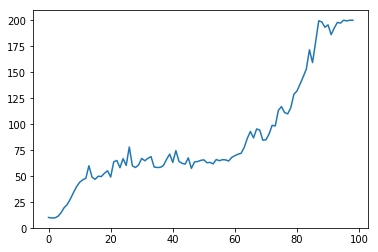

In [7]:
plt.figure()
plt.plot(np.arange(len(agent.mean_rew)), agent.mean_rew)
#plt.ylim([0, 1000])

In [7]:
##test

env1 = gym.make('CartPole-v0')
env2 = gym.make('HalfCheetah-v2')

In [12]:
env2.action_space

Box(6,)

In [13]:
env2.action_space.sample()

array([ 0.43037874,  0.20552675,  0.08976637, -0.1526904 ,  0.29178822,
       -0.12482557], dtype=float32)

In [10]:
env1.action_space.sample()

1

In [28]:
env2.action_space.high[0]

1.0

In [ ]:
#离散动作空间/连续动作空间 

In [1]:
import tensorflow as tf
import numpy as np
testx = tf.get_variable(name='testx', initializer=[[1,2,3],[2,3,1],[0,1,3],[4,5,6]])
#testx = tf.Variable([[1,2,3],[2,3,1],[0,1,3],[4,5,6]])

In [19]:
index_col = np.array([0,1,2,1]).reshape([-1,1])
index = np.hstack([np.arange(4).reshape([-1,1]), index_col])
print(index)
#index = 
y = tf.gather_nd(testx, index.tolist())
print('='*10)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(testx))
    print(sess.run(y))

[[0 0]
 [1 1]
 [2 2]
 [3 1]]
[[1 2 3]
 [2 3 1]
 [0 1 3]
 [4 5 6]]
[1 3 3 5]


In [5]:
np.array([0,1,2,1]).reshape([-1,1])

array([[0],
       [1],
       [2],
       [1]])

In [25]:
np.random.binomial(1, 0.1,10)

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [18]:
import tensorflow as tf
import numpy as np
a = np.array([1,3,4,5])
xa = tf.Variable(a, dtype=tf.int32)
y = tf.range(tf.shape(a)[0], dtype=tf.int32)
yy = tf.stack([y,xa], axis=1)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(xa))
    print(sess.run(y))
    print(sess.run(yy))


[1 3 4 5]
[0 1 2 3]
[[0 1]
 [1 3]
 [2 4]
 [3 5]]
